In [1]:
#pre-propcessing for gov and yelp data
import pandas as pd
import re
import numpy as np
import Levenshtein as lev
from dfply import *

gov_2017=pd.read_csv('./FoodEnv/SpatialData/Gov_Data2017.csv',usecols=['RECORDNAME','ADDRESS','CITY','STATE','ZIP','RECORDID','BUSINESSTY','LAT','LONG'])
gov_2020=pd.read_csv('./FoodEnv/SpatialData/Gov_Data2020.csv',usecols=['RECORDNAME','ADDRESS','CITY','STATE','ZIP','RECORDID','BUSINESSTY','LAT','LONG'])
yelp_2020=pd.read_csv('./FoodEnv/SpatialData/Yelp_Data.csv',usecols=['biz_name','biz_addres','biz_addr_1','biz_addr_2','biz_postal','yelp_categ','yelp_cat_1','biz_id','biz_latitu','biz_longit'],encoding='utf-8')
esri_2017=pd.read_csv('./FoodEnv/SpatialData/Esri_2017.csv',usecols=['LOCNUM','CONAME','STREET','CITY','STATE','ZIP','NAICS','POINT_X','POINT_Y'])



## Data Cleaning

In [ ]:
#clean address for yelp data
yelp_2020['biz_addres']=yelp_2020['biz_addres'].str.replace(r"[\\\',]", '')
yelp_2020['biz_addr_1']=yelp_2020['biz_addr_1'].str.replace(r"[\\\',]", '')
yelp_2020['biz_addr_2']=yelp_2020['biz_addr_2'].str.replace(r"[\\\',]", '')
yelp_2020['biz_postal']=yelp_2020['biz_postal'].str.replace(r"[\\\',]", '')

#clean category column in yelp data
yelp_2020['yelp_categ']=yelp_2020['yelp_categ'].str.replace(r"[\\\',]", '')
yelp_2020['yelp_cat_1']=yelp_2020['yelp_cat_1'].str.replace(r"[\\\',]", '')

#remove # in store names in gov data
gov_2017['RECORDNAME']=[re.sub('#[^\s]+', '', i) for i in gov_2017['RECORDNAME']]
gov_2020['RECORDNAME']=[re.sub('#[^\s]+', '', i) for i in gov_2020['RECORDNAME']]

#lower case for address and store names for all data
gov_2017['RECORDNAME']=gov_2017['RECORDNAME'].str.lower()
gov_2020['RECORDNAME']=gov_2020['RECORDNAME'].str.lower()
gov_2017['ADDRESS']=gov_2017['ADDRESS'].str.lower()
gov_2020['ADDRESS']=gov_2020['ADDRESS'].str.lower()

yelp_2020['biz_name']=yelp_2020['biz_name'].str.lower()
esri_2017['CONAME']=esri_2017['CONAME'].str.lower()
esri_2017['STREET']=esri_2017['STREET'].str.lower()

#extract # in address and add to STE for gov and yelp
gov_2017['STE'] = np.select([gov_2017.ADDRESS.str.contains('#')], 
                            [gov_2017.ADDRESS.apply(lambda x: x[x.find('#'):])], 
                            default = '')
gov_2017['STE']=gov_2017['STE'].str[2:]

gov_2020['STE'] = np.select([gov_2020.ADDRESS.str.contains('#')], 
                            [gov_2020.ADDRESS.apply(lambda x: x[x.find('#'):])], 
                            default = '')
gov_2020['STE']=gov_2020['STE'].str[2:]

# what has not been done: 
## Address in YELP data need cleaning; 
## Records with missing address are currently kept;
## Category was not lower cased
## Only address is cleaned, city, state and zip are not cleaned, consider to drop these

In [ ]:
#assign new column names
new_cols_gov=['G_NAME','G_Catg','G_ADDRESS','G_CITY','G_STATE','G_ZIP','G_RECORDID','G_LAT','G_LONG','G_STE']
new_cols_esri=['E_RECORDID','E_NAME','E_ADDRESS','E_CITY','E_STATE','E_ZIP','E_NAICS','E_LONG','E_LAT']
new_cols_yelp=['Y_NAME','Y_LAT','Y_LONG','Y_ADDRESS','Y_CITY','Y_STATE','Y_ZIP','Y_Ctg','Y_Ctg1','Y_RECORDID','Y_STE']

gov_2017.columns=new_cols_gov
gov_2020.columns=new_cols_gov
yelp_2020.columns=new_cols_yelp
esri_2017.columns=new_cols_esri



In [ ]:
########Data cleaning################

#clean duplicates for yelp

#get first category in Y_Ctg1
s = yelp_2020.Y_Ctg1.str.split('.') #find separator in column Y_Ctg1 .
yelp_2020['Y_Ctg_lv1']=np.where(s.str.len()==1,'',s.str[0]) #retrieve the word before the separator

#drop uplicates using name, address, city, zip and category
yelp_2020_clean=yelp_2020.drop_duplicates(subset=['Y_NAME','Y_ADDRESS','Y_CITY','Y_ZIP','Y_Ctg_lv1'],
                                         keep='last').reset_index(drop=True)
yelp_2020_clean.to_csv('./FoodEnv/SpatialData/yelp_2020clean2.csv',index=False)

#check results that were excluded
#yelp_to_join=yelp_2020_clean[['Y_RECORDID','Y_LAT']]
#yelp_all=pd.merge(yelp_2020,yelp_to_join,on='Y_RECORDID',how='outer')

#yelp_duplicates=yelp_all[yelp_all['Y_LAT_y'].isnull()]
#yelp_duplicates.to_csv('./FoodEnv/SpatialData/yelp_duplicates.csv',index=False)

In [ ]:
#clean duplicates for esri

#remove duplicates where all attributes are identical
esri_2017_nodup=esri_2017.drop_duplicates(subset=['E_NAME','E_ADDRESS','E_CITY','E_ZIP','E_LAT','E_LONG'],
                                         keep='last').reset_index(drop=True)
#find duplicates in address, city and zip,lat, long
esri_2017_duplic=esri_2017_nodup[esri_2017_nodup.duplicated(subset=['E_ADDRESS','E_CITY','E_ZIP','E_LAT','E_LONG'],keep=False)]
esri_2017_duplic['E_coords']=esri_2017_duplic.apply(lambda x:'%s,%s' % (x['E_LAT'],x['E_LONG']),axis=1)
esri_2017_duplic=esri_2017_duplic[['E_RECORDID','E_NAME','E_NAICS','E_coords']]

#make another dataset that is the same with esri_2017_duplic
esri_2017_duplic_v2=pd.DataFrame()
esri_2017_duplic_v2=esri_2017_duplic[['E_RECORDID','E_NAME','E_NAICS','E_coords']]
#give new column names
esri_2017_duplic_v2.columns=['E_RECORDID2','E_NAME2','E_NAICS2','E_coords2']


esri_2017_duplic['E_NAME'].count()

In [ ]:
#get similarity score of store names between location duplicates
esri_twosets=esri_2017_duplic.merge(esri_2017_duplic_v2,left_on='E_coords',right_on='E_coords2',how='outer')
name_dist=esri_twosets.apply(lambda x: lev.distance(x['E_NAME'],  x['E_NAME2']), axis=1)
name_dist_df=pd.DataFrame(name_dist,columns=['lev_dist'])
name_match_esri=esri_twosets.join(name_dist_df)
name_match_esri=name_match_esri.loc[~(name_match_esri['E_RECORDID'] == name_match_esri['E_RECORDID2'])]
name_match_esri.to_csv('./FoodEnv/SpatialData/esri_duplicates.csv',index=False)

#find records with a low similarity score, and drop one of them based on coordinates
#this is a manual checking step and saved as esri_duplicates_clean, lev_dist<6 was set as threshold


In [ ]:
#drop duplicate records based on ID, merge other info back
esri_clean=pd.read_csv('./FoodEnv/SpatialData/esri_duplicates.csv')

#find the records that should be removed and retrieve RECORDID
esri_to_drop=esri_clean>>filter_by(X.Keep==0)>>select(X.E_RECORDID)
#remove these records from the original data
esri_final_data=esri_2017_nodup[~esri_2017_nodup.E_RECORDID.isin(esri_to_drop.E_RECORDID)]
esri_final_data['E_NAME'].count()

esri_final_data.to_csv('./FoodEnv/SpatialData/esri_clean_final.csv',index=False)


In [ ]:
#repeat cleaning process for gov data
#remove duplicates where all attributes are identical
gov_nodup=gov_2020.drop_duplicates(subset=['G_NAME','G_ADDRESS','G_CITY','G_ZIP','G_LAT','G_LONG'],
                                         keep='last').reset_index(drop=True)
#find duplicates in address, city and zip,lat, long
gov_duplic=gov_nodup[gov_nodup.duplicated(subset=['G_ADDRESS','G_CITY','G_ZIP','G_LAT','G_LONG'],keep=False)]
gov_duplic['G_coords']=gov_duplic.apply(lambda x:'%s,%s' % (x['G_LAT'],x['G_LONG']),axis=1)
gov_duplic=gov_duplic[['G_RECORDID','G_NAME','G_coords']]

#make another dataset that is the same with gov_duplic
gov_duplic_v2=pd.DataFrame()
gov_duplic_v2=gov_duplic[['G_RECORDID','G_NAME','G_coords']]
#give new column names
gov_duplic_v2.columns=['G_RECORDID2','G_NAME2','G_coords2']


gov_duplic['G_NAME'].count()



In [ ]:
#get similarity score of store names between location duplicates
gov_twosets=gov_duplic.merge(gov_duplic_v2,left_on='G_coords',right_on='G_coords2',how='outer')
name_dist=gov_twosets.apply(lambda x: lev.distance(x['G_NAME'],  x['G_NAME2']), axis=1)
name_dist_df=pd.DataFrame(name_dist,columns=['lev_dist'])
name_match_gov=gov_twosets.join(name_dist_df)
name_match_gov=name_match_gov.loc[~(name_match_gov['G_RECORDID'] == name_match_gov['G_RECORDID2'])]
name_match_gov.to_csv('./FoodEnv/SpatialData/gov2020_duplicates.csv',index=False)

#find records with a low similarity score, and drop one of them based on coordinates
#this is a manual checking step and saved as esri_duplicates_clean, lev_dist<6 was set as threshold

In [ ]:
#drop duplicate records based on ID, merge other info back
gov_clean=pd.read_csv('./FoodEnv/SpatialData/gov2020_duplicates.csv')
#find the records that should be removed and retrieve RECORDID
gov_to_drop=gov_clean>>filter_by(X.Keep==0)>>select(X.G_RECORDID)
#remove these records from the original data
gov_final_data=gov_nodup[~gov_nodup.G_RECORDID.isin(gov_to_drop.G_RECORDID)]
#gov_final_data['G_NAME'].count()

gov_final_data.to_csv('./FoodEnv/SpatialData/gov_clean_final.csv',index=False)

In [ ]:
#addresses were fixed for yelp data
yelp_add_cor=pd.read_csv("./FoodEnv/SpatialData/yelp_ID_add_clean_v2.csv",usecols=['biz_id','biz_address_clean'])
#merge to yelp cleaned data based on biz_id
#extract ste (update ste column)
yelp_cleaned=pd.read_csv("./FoodEnv/SpatialData/yelp_2020clean2.csv")
yelp_add_merge=yelp_cleaned.merge(yelp_add_cor,left_on='Y_RECORDID',right_on='biz_id',how='inner')
yelp_add_merge=yelp_add_merge[['Y_NAME','Y_LAT','Y_LONG','biz_address_clean','Y_CITY','Y_STATE','Y_ZIP','Y_Ctg','Y_Ctg1','Y_RECORDID','Y_Ctg_lv1']]
yelp_add_merge.columns=['Y_NAME','Y_LAT','Y_LONG','Y_ADDRESS','Y_CITY','Y_STATE','Y_ZIP','Y_Ctg','Y_Ctg1','Y_RECORDID','Y_Ctg_lv1']
yelp_add_merge['Y_ADDRESS']=yelp_add_merge['Y_ADDRESS'].str.lower()


In [ ]:
pat =  r'.*?(?P<Unit_type>ste|unit|bldg|#|section|suite|store) (?P<Y_STE>.+)'
ste=yelp_add_merge.Y_ADDRESS.str.extract(pat)
yelp_add_merge=yelp_add_merge.join(ste['Y_STE'])
yelp_add_merge.to_csv('./FoodEnv/SpatialData/yelp_clean_final.csv')


#data cleaning done

## spatial data processing

In [ ]:
import pandas as pd
test =  pd.read_csv("./FoodEnv/SpatialData/yelp_clean_final.csv")
duplicateRows = test [test.duplicated(['Y_RECORDID'])]

In [ ]:
duplicateRows

In [ ]:
import arcpy

arcpy.env.workspace = r"C:\Users\yanji\Documents\COHProjects\FoodEstab\FoodEnv\SpatialData"
arcpy.env.overwriteOutput = True

input_data='yelp_clean_final.csv' #change input
input_x="Y_LONG" #change input
input_y="Y_LAT" #change input
out_layer='yelp_2020.shp'
project_out='yelp_2020prj.shp'

#XY to shapefile
food_pt=arcpy.management.XYTableToPoint(input_data, out_layer, input_x, input_y,'',arcpy.SpatialReference(4326))

#project the point features to prepare for distance computation
out_coordinate_system = arcpy.SpatialReference('NAD 1983 UTM Zone 11N')
# run the tool
food_prj=arcpy.Project_management(food_pt, project_out, out_coordinate_system)



In [ ]:
#candidate dataset:'gov_2020prj.shp','esri_2017prj.shp','yelp_2020prj.shp'
#change input data in the following code to run the function


#point feature to the nearest point in another datset;modify the table, no new output
arcpy.Near_analysis('esri_2017prj.shp', 'yelp_2020prj.shp')

#get the median value of distance between nearest points
arcpy.TableToTable_conversion('esri_2017prj.shp', arcpy.env.workspace, 'esri_yelp_dist.csv')
out_table=pd.read_csv("./FoodEnv/SpatialData/esri_yelp_dist.csv")
out_table['NEAR_DIST'].median()

In [ ]:
#spatial join within a distance: 100 meters
target_feature=r"./FoodEnv/SpatialData/gov_2020prj.shp" #change data input for other dataset
join_feature=r"./FoodEnv/SpatialData/yelp_2020prj.shp"
out_feature=r"./FoodEnv/SpatialData/gov_yelp1000m.shp"
join_operation="JOIN_ONE_TO_MANY"
match_option="WITHIN_A_DISTANCE" #could use WITHIN_DISTANCE in future work instead of creating buffer
search_radius='1000 Meters'

arcpy.SpatialJoin_analysis(target_feature, join_feature, out_feature,join_operation,"#","#",match_option,search_radius)
arcpy.TableToTable_conversion('gov_yelp1000m.shp', arcpy.env.workspace, 'gov_yelp1000m.csv')


In [ ]:
##############a subset code for 3 data join##################
#get cleaning data for new spatial join
esri_gov_to_clean=pd.read_csv('./FoodEnv/SpatialData/esri_gov_matchtest.csv',
                              usecols=['G_NAME', 'G_Catg','G_ADDRESS', 'G_CITY', 'G_STATE', 
                                       'G_ZIP', 'G_RECORDID', 'G_LAT','G_LONG', 'G_STE', 'E_RECORDID',
                                       'E_NAME', 'E_ADDRESS', 'E_CITY','E_STATE', 'E_ZIP', 'E_NAICS', 
                                       'E_LONG', 'E_LAT'])
esri_gov_to_clean.to_csv('./FoodEnv/SpatialData/esri_gov_clean.csv')

In [ ]:
#join yelp data with esri_gov data

input_data='esri_gov_clean.csv' #change input
input_x="G_LONG" #change input
input_y="G_LAT" #change input
out_layer='esri_gov.shp'
project_out='esri_gov_prj.shp'

#XY to shapefile
food_pt=arcpy.management.XYTableToPoint(input_data, out_layer, input_x, input_y,'',arcpy.SpatialReference(4326))

#project the point features to prepare for distance computation
out_coordinate_system = arcpy.SpatialReference('NAD 1983 UTM Zone 11N')
# run the tool
food_prj=arcpy.Project_management(food_pt, project_out, out_coordinate_system)

In [ ]:
#spatial join buffer to point -- within a distance: 100 meters
#candidate dataset:'gov_2020prj.shp','esri_2017prj.shp','yelp_2020prj.shp'
target_feature=r"./FoodEnv/SpatialData/yelp_2020prj.shp" #change data input for other dataset
join_feature=r"./FoodEnv/SpatialData/esri_2017prj.shp"
out_feature=r"./FoodEnv/SpatialData/yelp_esri1000m.shp"
join_operation="JOIN_ONE_TO_MANY"
match_option="WITHIN_A_DISTANCE" #could use WITHIN_DISTANCE in future work instead of creating buffer
search_radius='1000 Meters'

arcpy.SpatialJoin_analysis(target_feature, join_feature, out_feature,join_operation,"#","#",match_option,search_radius)
arcpy.TableToTable_conversion('yelp_esri1000m.shp', arcpy.env.workspace, 'yelp_esri1000m.csv')

## Matching lat/long and store names to drop duplicates

In [ ]:
import pandas as pd
from dfply import *
import Levenshtein as lev
from metaphone import doublemetaphone

In [ ]:
#data candidates:esri_yelp1000m,gov_esri1000m,gov_yelp1000m
join_table=pd.read_csv("./FoodEnv/SpatialData/esri_yelp1000m.csv")
gps_list=['Y_LAT','Y_LONG','E_LAT','E_LONG']
gps_offset=0.001
name_list=['Y_NAME','E_NAME']
lev_dist_threshold=4
dm_threshold=2

#remove rows with no esri pt
join_table['lat_dff']=abs(join_table[gps_list[0]]-join_table[gps_list[2]])
join_table['long_dff']=abs(join_table[gps_list[1]]-join_table[gps_list[3]])

#location match
join_table_1=join_table>>filter_by(X.Join_Count>0)
#print(join_table_1['OID_'].count())

#GPS match
join_table_2=join_table_1>>filter_by(X.lat_dff<gps_offset, X.long_dff<gps_offset)
#print(join_table_2['OID_'].count())

#unique number of POIs after GPS matching
#x=len(join_table_2['G_RECORDID'].unique())
#print('After GPS Match:',x)

#store name match
join_table_2['lev_dist']=join_table_2.apply(lambda x: lev.distance(x[name_list[0]],  x[name_list[1]]), axis=1)
#lev_dist_df=pd.DataFrame(lev_dist,columns=['lev_dist'])
name_match=join_table_2>>filter_by(X.lev_dist<=lev_dist_threshold)
#print(name_match['OID_'].count())

#DM on store name
name_match['DM1'] = name_match.apply(lambda x: doublemetaphone(str(x[name_list[0]]))[0], axis=1)
name_match['DM2']=name_match.apply(lambda x: doublemetaphone(str(x[name_list[1]]))[0], axis=1)
name_match['DM_lev']=name_match.apply(lambda x: lev.distance(x['DM1'],  x['DM2']), axis=1)
name_dm=name_match>>filter_by(X.DM_lev<=dm_threshold)

#unique number of POIs after name matching
rec=len(name_dm['Y_RECORDID'].unique())
print('After Name Match:',rec)

In [ ]:
#######Extra steps for Gov & ESRI Match

#extra steps for cleaning duplicates for esri gas stations and similar names using smaller lev index

#step1: If duplicate in RECORDID, then keep the one with lower lev score
name_match_clean1= name_dm.groupby(['G_RECORDID','E_NAICS'])['lev_dist'].idxmin()

#for esri matching data (joining in gov or yelp), if duplicate in RECORDID, then drop records where NAICS=44719005
#sort by NAICS, keep the smaller NAICS if duplicate in gov recordid
name_match_clean2=name_dm.loc[name_match_clean1].groupby(['G_RECORDID'])['E_NAICS'].idxmin()
name_match_clean3= name_dm.loc[name_match_clean2].groupby(['E_RECORDID'])['lev_dist'].idxmin()
#save processed data
gov_esri_match_final=name_dm.loc[name_match_clean3]

gov_esri_match_final['E_RECORDID'].count()

gov_esri_match_final.to_csv('./FoodEnv/SpatialData/esri_gov_match0419.csv',index=False)

In [ ]:
#######Extra steps for Gov & Yelp Match

#If duplicate in RECORDID, then keep the one with lower lev score
name_match_clean1= name_dm.groupby(['G_RECORDID'])['lev_dist'].idxmin()
name_match_clean2= name_dm.loc[name_match_clean1].groupby(['Y_RECORDID'])['lev_dist'].idxmin()
#save processed data
gov_yelp_match_final=name_dm.loc[name_match_clean2]

gov_yelp_match_final.to_csv('./FoodEnv/SpatialData/gov_yelp_match0419.csv',index=False)

In [ ]:
#######Extra steps for Esri & Yelp Match

#step1: If duplicate in RECORDID, then keep the one with lower lev score
name_match_clean1= name_dm.groupby(['Y_RECORDID'])['lev_dist'].idxmin()
name_match_clean2= name_dm.loc[name_match_clean1].groupby(['E_RECORDID'])['lev_dist'].idxmin()

#save processed data
yelp_esri_match_final=name_dm.loc[name_match_clean2]
yelp_esri_match_final.to_csv('./FoodEnv/SpatialData/esri_yelp_match0419.csv',index=False)

In [ ]:
len(gov_esri_match_final['E_RECORDID'].unique())

In [ ]:
#merge gov_yelp and gov_esri
gov_esri_yelp=gov_yelp_match_final.merge(gov_esri_match_final,on='G_RECORDID',how='inner')
gov_esri_yelp.to_csv('./FoodEnv/SpatialData/esri_yelp_gov_match0419.csv',index=False)

gov_esri_yelp['G_RECORDID'].count()

In [ ]:
#extract the unmatched records from each dataset
gov_full=pd.read_csv("./FoodEnv/SpatialData/gov_clean_final.csv")
yelp_full=pd.read_csv("./FoodEnv/SpatialData/yelp_clean_final.csv")
esri_full=pd.read_csv("./FoodEnv/SpatialData/esri_clean_final.csv")

gov_unmatch=gov_full[~gov_full['G_RECORDID'].isin(gov_esri_yelp['G_RECORDID'])]
yelp_unmatch=yelp_full[~yelp_full['Y_RECORDID'].isin(gov_esri_yelp['Y_RECORDID'])]
esri_unmatch=esri_full[~esri_full['E_RECORDID'].isin(gov_esri_yelp['E_RECORDID'])]

#save data for weighted ranking match
gov_unmatch.to_csv('./FoodEnv/SpatialData/gov_unmatch0419.csv',index=False)
yelp_unmatch.to_csv('./FoodEnv/SpatialData/yelp_unmatch0419.csv',index=False)
esri_unmatch.to_csv('./FoodEnv/SpatialData/esri_unmatch0419.csv',index=False)

print(gov_unmatch['G_RECORDID'].count(),yelp_unmatch['Y_RECORDID'].count(),esri_unmatch['E_RECORDID'].count())                 

In [ ]:
#some extra work for the low confidence matched data -- gov
gov_full=pd.read_csv("./FoodEnv/SpatialData/gov_clean_final.csv",usecols=['G_RECORDID','G_NAME','G_Catg','G_LAT','G_LONG'])
gov_tomerge=pd.read_csv("./FoodEnv/SpatialData/esri_yelp_gov_500rank.csv",usecols=['G_RECORDID'])
gov_add=gov_tomerge.merge(gov_full,on='G_RECORDID',how='inner')
gov_add.to_csv("./FoodEnv/SpatialData/esri_yelp_gov_500rank_govadd.csv")


## Sensitivity analysis

In [ ]:
###########sensitivity analysis##################
#data candidates: "yelp_esri1000m",'gov_yelp1000m','gov_esri1000m'
join_table=pd.read_csv("./FoodEnv/SpatialData/esri_yelp1000m.csv")
gps_list=['E_LAT','E_LONG','Y_LAT','Y_LONG']
name_list=['E_NAME','Y_NAME']


#remove rows with no esri pt
join_table['lat_dff']=abs(join_table[gps_list[0]]-join_table[gps_list[2]])
join_table['long_dff']=abs(join_table[gps_list[1]]-join_table[gps_list[3]])

#location match
join_table_1=join_table>>filter_by(X.Join_Count>0)

gps_offset=[0.0005,0.00075,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
#gps_offset=[0.005]
file_name=['50m','75m','100m','200m','300m','400m','500m','600m','700m','800m','900m','1000m']
#file_name=['500m']
lev_dist_threshold=[2,3,4,5,6,7,8,9]

for i in range (0,12):
    for j in range (0,8):
        join_table_2=join_table_1>>filter_by(X.lat_dff<gps_offset[i], X.long_dff<gps_offset[i])
        lev_dist=join_table_2.apply(lambda x: lev.distance(x[name_list[0]],  x[name_list[1]]), axis=1)
        lev_dist_df=pd.DataFrame(lev_dist,columns=['lev_dist'])
        name_match=join_table_2.join(lev_dist_df)>>filter_by(X.lev_dist<=lev_dist_threshold[j])
        #follow above code for different dataset
        name_match_clean1= name_match.groupby(['Y_RECORDID'])['lev_dist'].idxmin()
        name_match_clean2= name_match.loc[name_match_clean1].groupby(['E_RECORDID'])['lev_dist'].idxmin()
        #save processed data
        yelp_esri_match_final=name_match.loc[name_match_clean2]
        yelp_esri_match_final.to_csv('./FoodEnv/SpatialData/SensTest/NewTest/esri_yelp_match{0}{1}.csv'.format(file_name[i],lev_dist_threshold[j]),index=False)
        rec=len(name_match['Y_RECORDID'].unique())
        print (rec)

In [ ]:
#merge gov_yelp and gov_esri, sensitivity test

for i in range (0,12):
    for j in range (0,8):
        gov_esri_match=pd.read_csv('./FoodEnv/SpatialData/SensTest/NewTest/gov_esri_match{0}{1}.csv'.format(file_name[i],lev_dist_threshold[j]))
        gov_yelp_match=pd.read_csv('./FoodEnv/SpatialData/SensTest/NewTest/gov_yelp_match{0}{1}.csv'.format(file_name[i],lev_dist_threshold[j]))
        gov_esri_yelp=gov_yelp_match.merge(gov_esri_match,on='G_RECORDID',how='inner')
        #gov_esri_yelp.to_csv('./FoodEnv/SpatialData/SensTest/NewTest/gov_esri_yelp_match{0}{1}.csv'.format(file_name[i],lev_dist_threshold[j]),index=False)
        rec=gov_esri_yelp['G_RECORDID'].count()
        print (rec)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

poi_data=pd.read_csv('./FoodEnv/SpatialData/SensTest/Sensitivity_Analysis_newtest.csv').dropna()
poi_data.head

<bound method NDFrame.head of     Distance (m)  Lev_Dist  Yelp_Gov  Gov_Esri  Esri_Yelp       YG_G  \
0             50         2      2763      2226       3493  31.562714   
1             50         3      2915      2328       3597  33.299063   
2             50         4      3065      2498       3804  35.012566   
3             50         5      3158      2613       3927  36.074937   
4             50         6      3318      2778       4123  37.902673   
..           ...       ...       ...       ...        ...        ...   
91          1000         5      4515      3834       5677  51.576422   
92          1000         6      4885      4285       6296  55.803061   
93          1000         7      5400      4899       6961  61.686086   
94          1000         8      5779      5328       7637  66.015536   
95          1000         9      6145      5732       8322  70.196482   

         YG_Y     YG_Avg       EG_E       EG_G     EG_Avg       EY_E  \
0   21.480215  26.521464  20.6302

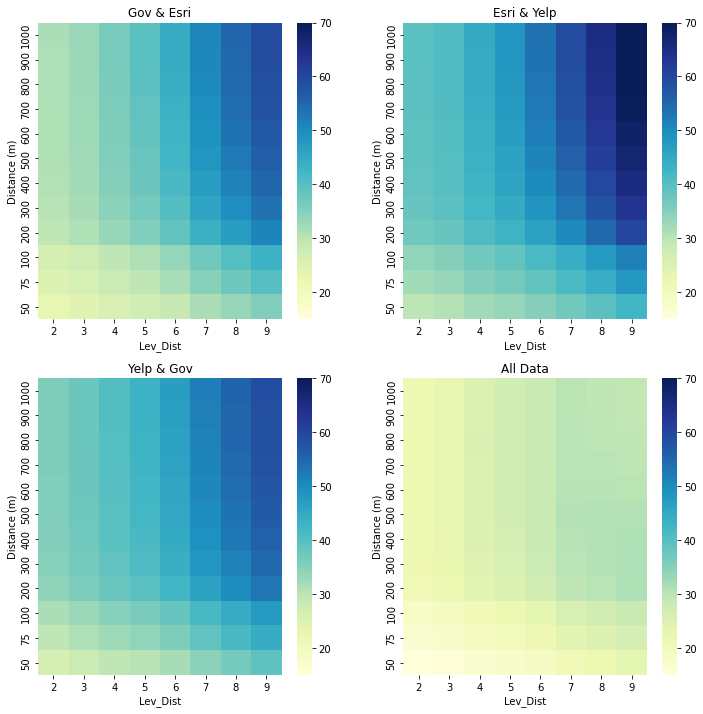

In [3]:
#plot for number of POI
poi_to_plot1=poi_data.reset_index().pivot(index='Distance (m)',columns='Lev_Dist',values='EG_Avg')
poi_to_plot2=poi_data.reset_index().pivot(index='Distance (m)',columns='Lev_Dist',values='EY_Avg')
poi_to_plot3=poi_data.reset_index().pivot(index='Distance (m)',columns='Lev_Dist',values='YG_Avg')
poi_to_plot4=poi_data.reset_index().pivot(index='Distance (m)',columns='Lev_Dist',values='All_Avg')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,12))

sb.heatmap(poi_to_plot1,ax=ax1, cmap="YlGnBu",vmin=15,vmax=70)
sb.heatmap(poi_to_plot2,ax=ax2, cmap="YlGnBu",vmin=15,vmax=70)
sb.heatmap(poi_to_plot3,ax=ax3, cmap="YlGnBu",vmin=15,vmax=70)
sb.heatmap(poi_to_plot4,ax=ax4, cmap="YlGnBu",vmin=15,vmax=70)

ax1.invert_yaxis() #reverse values on y axis
ax2.invert_yaxis()
ax3.invert_yaxis()
ax4.invert_yaxis()

ax1.set_title('Gov & Esri')
ax2.set_title('Esri & Yelp')
ax3.set_title('Yelp & Gov')
ax4.set_title('All Data')
plt.show()
#plt.savefig('./FoodEnv/SpatialData/SensTest/POINumber.jpg', dpi=250)

In [4]:
poi_to_plot1.head()

Lev_Dist,2,3,4,5,6,7,8,9
Distance (m),,,,,,,,
50,23.029294,24.084545,25.843296,27.033040,28.740063,31.347153,33.405926,35.516427
75,24.953575,26.143318,28.077945,29.526328,31.657521,34.916383,37.378635,40.016761
100,26.288157,27.519283,29.588402,31.191969,33.612838,37.275179,40.151254,43.223896
200,29.567710,30.922983,33.385235,35.485391,38.702871,43.710139,47.269023,50.900327
300,30.426395,31.843741,34.481868,36.871700,40.358166,45.851677,49.720929,53.486726


## Manual check process

In [ ]:
import os
import pandas as pd

In [ ]:
#select random samples for manual check

path,dirs,files=next(os.walk("./FoodEnv/SpatialData/SensTest/ForManualCheck/"))
file_count=len(files)

for i in range(file_count):
    temp_df=pd.read_csv("./FoodEnv/SpatialData/SensTest/ForManualCheck/"+files[i])
    temp_df_lev_3=temp_df>>filter_by(X.lev_dist==3)>>sample(frac=0.5)>>select(ends_with('NAME'),ends_with('RECORDID'),X.lev_dist)
    temp_df_lev_4=temp_df>>filter_by(X.lev_dist==4)>>sample(frac=0.5)>>select(ends_with('NAME'),ends_with('RECORDID'),X.lev_dist)
    temp_df_lev_5=temp_df>>filter_by(X.lev_dist==5)>>sample(frac=0.5)>>select(ends_with('NAME'),ends_with('RECORDID'),X.lev_dist)
    #rec_3=temp_df_lev_3['OID_'].count()
    #rec_4=temp_df_lev_4['OID_'].count()
    #rec_5=temp_df_lev_5['OID_'].count()
    
    temp_df_lev_3.to_csv('./FoodEnv/SpatialData/SensTest/{0}_lev3.csv'.format(files[i][:-4]),index=False)
    temp_df_lev_4.to_csv('./FoodEnv/SpatialData/SensTest/{0}_lev4.csv'.format(files[i][:-4]),index=False)
    temp_df_lev_5.to_csv('./FoodEnv/SpatialData/SensTest/{0}_lev5.csv'.format(files[i][:-4]),index=False)
    #print ( rec_3,rec_4,rec_5)

In [ ]:
#compute % of manual matching
path,dirs,files=next(os.walk("./FoodEnv/SpatialData/SensTest/Results/"))
file_count=len(files)

for i in range(file_count):
    temp_df=pd.read_csv("./FoodEnv/SpatialData/SensTest/Results/"+files[i])
    all_rec1=temp_df['Same_Business_1'].count()
    mark_rec1=temp_df['Same_Business_1'].sum()
    ratio_rec1=round(mark_rec1/all_rec1,2)
    all_rec2=temp_df['Same_Business_2'].count()
    mark_rec2=temp_df['Same_Business_2'].sum()
    ratio_rec2=round(mark_rec2/all_rec2,2)
    ratio_avg=(ratio_rec1+ratio_rec2)*100/2
    print('{0} '.format(files[i][:-4]),ratio_avg)

In [ ]:
#compute aggrement ratio
path,dirs,files=next(os.walk("./FoodEnv/SpatialData/SensTest/Results/"))
file_count=len(files)

for i in range(file_count):
    temp_df=pd.read_csv("./FoodEnv/SpatialData/SensTest/Results/"+files[i])
    #assign 1 if different among annotators
    temp_df['agg_diff']=abs(temp_df['Same_Business_1']-temp_df['Same_Business_2'])
    #total records
    all_rec=temp_df['Same_Business_1'].count()
    #total difference
    diff_rec=temp_df['agg_diff'].sum()
    #aggrement rate
    ratio_agg=round((all_rec-diff_rec)/all_rec*100,2)
    print('{0} '.format(files[i][:-4]),ratio_agg)

In [ ]:
#compute DM and apply Lev dist
import Levenshtein as lev
from metaphone import doublemetaphone

path,dirs,files=next(os.walk("./FoodEnv/SpatialData/SensTest/Results/"))
file_count=len(files)

for i in range(file_count):
    temp_df=pd.read_csv("./FoodEnv/SpatialData/SensTest/Results/"+files[i])
    temp_df['DM1'] = temp_df.apply(lambda x: doublemetaphone(str(x[temp_df.columns[3]]))[0], axis=1)
    temp_df['DM2']=temp_df.apply(lambda x: doublemetaphone(str(x[temp_df.columns[4]]))[0], axis=1)
    temp_df['DM_lev']=temp_df.apply(lambda x: lev.distance(x['DM1'],  x['DM2']), axis=1)
    #selec_rec=temp_df[(temp_df.Same_Business1!=0)|(temp_df.Same_Business2!=0) | (temp_df.DM_lev<2)]
    #take the opposite records of conditions
    selec_rec=temp_df[~((temp_df.Same_Business_1==0)&(temp_df.Same_Business_2==0)&(temp_df.DM_lev>3))]
    #total records
    all_rec=selec_rec['Same_Business_1'].count()
    match_rec1=selec_rec['Same_Business_1'].sum()
    match_rec2=selec_rec['Same_Business_2'].sum()
    manual_check_rate=round(((match_rec1/all_rec)*100+(match_rec2/all_rec)*100)/2,2)
    print(manual_check_rate)
    

# Category analysis from matched and unmatched

In [210]:
#matched data
all_match_data=pd.read_csv("./FoodEnv/SpatialData/All_FullMatch.csv")
all_match_data.columns
all_match_data.count()

G_NAME        5465
G_Ctg         5465
G_RECORDID    5465
G_LAT         5465
G_LONG        5465
Y_RECORDID    5465
Y_NAME        5465
Y_Ctg         5465
Y_LAT         5465
Y_LONG        5465
E_RECORDID    5465
E_NAME        5465
E_NAICS       5465
E_LONG        5465
E_LAT         5465
LowConf       5465
dtype: int64

In [206]:
#merge yelp data with new category
yelp_new=pd.read_csv("./FoodEnv/SpatialData/yelp_clean_final.csv",usecols=['Y_RECORDID','Y_Ctg_all','Y_Ctg_top',
                                                                           'Y_Ctg_food_and_res','Y_Ctg_food',
                                                                           'Y_Ctg_res'])
all_match_data_newctg=all_match_data.merge(yelp_new,on='Y_RECORDID',how='inner') #final match data with new yelp category

#categories in yelp
all_keys = []

for e in all_match_data_newctg['Y_Ctg_all']:
    all_keys += eval(e) #use eval to retrieve all the values in Y_Ctg_all, while e is a string

row_num=all_match_data_newctg.shape[0]
ctg_count=pd.value_counts(all_keys)
yelp_ctg=pd.DataFrame({'Category':ctg_count.index, 'Count':ctg_count.values})
yelp_ctg['Perc']=yelp_ctg['Count']/row_num*100
yelp_ctg.to_csv("./FoodEnv/SpatialData/match_yelp_ctg.csv")

In [209]:
#categories in gov
gov_ctg=all_match_data.groupby(['G_Ctg']).size().reset_index(name='Count')
gov_ctg['Perc']=gov_ctg['Count']/row_num*100
gov_ctg.to_csv("./FoodEnv/SpatialData/match_gov_ctg.csv")

#categories in esri
esri_ctg=all_match_data.groupby(['E_NAICS']).size().reset_index(name='Count')
esri_ctg.to_csv("./FoodEnv/SpatialData/match_esri_ctg.csv")

In [ ]:
#different categories in low confident and high confident data
low_conf=all_match_data>>filter_by(X.LowConf==1)
high_conf=all_match_data>>filter_by(X.LowConf==0)
#low_conf_G_Ctg=low_conf.groupby(['G_Ctg']).size().reset_index(name='counts')
low_conf_Y_Ctg=low_conf.groupby(['Y_Ctg']).size().reset_index(name='counts')
#low_conf_E_Ctg=low_conf.groupby(['E_NAICS']).size().reset_index(name='counts')


In [213]:
#final unmatch data for each dataset
gov_full=pd.read_csv("./FoodEnv/SpatialData/gov_clean_final.csv")
yelp_full=pd.read_csv("./FoodEnv/SpatialData/yelp_clean_final.csv")
esri_full=pd.read_csv("./FoodEnv/SpatialData/esri_clean_final.csv")

gov_unmatch_final=gov_full[~gov_full['G_RECORDID'].isin(all_match_data_newctg['G_RECORDID'])]
yelp_unmatch_final=yelp_full[~yelp_full['Y_RECORDID'].isin(all_match_data_newctg['Y_RECORDID'])]
esri_unmatch_final=esri_full[~esri_full['E_RECORDID'].isin(all_match_data_newctg['E_RECORDID'])]


print(gov_unmatch_final['G_RECORDID'].count(),yelp_unmatch_final['Y_RECORDID'].count(),esri_unmatch_final['E_RECORDID'].count())   

#get category info

#categories in yelp
all_keys = []

for e in yelp_unmatch_final['Y_Ctg_all']:
    all_keys += eval(e) #use eval to retrieve all the values in Y_Ctg_all, while e is a string

row_num_yelp=yelp_unmatch_final.shape[0]
ctg_count=pd.value_counts(all_keys)
yelp_ctg=pd.DataFrame({'Category':ctg_count.index, 'Count':ctg_count.values})
yelp_ctg['Perc']=yelp_ctg['Count']/row_num_yelp*100
yelp_ctg.to_csv("./FoodEnv/SpatialData/unmatch_yelp_ctg.csv")

#categories in gov
row_num_gov=gov_unmatch_final.shape[0]
gov_ctg=gov_unmatch_final.groupby(['G_Catg']).size().reset_index(name='Count')
gov_ctg['Perc']=gov_ctg['Count']/row_num_gov*100
gov_ctg.to_csv("./FoodEnv/SpatialData/unmatch_gov_ctg.csv")

#categories in esri
esri_ctg=esri_unmatch_final.groupby(['E_NAICS']).size().reset_index(name='Count')
esri_ctg.to_csv("./FoodEnv/SpatialData/unmatch_esri_ctg.csv")

3289 7398 5325


In [222]:
gov_unmatch_final.to_csv("./FoodEnv/SpatialData/gov_unmatch_final.csv")
yelp_unmatch_final.to_csv("./FoodEnv/SpatialData/yelp_unmatch_final.csv")
esri_unmatch_final.to_csv("./FoodEnv/SpatialData/esri_unmatch_final.csv")

In [221]:
#explore yelp categories
yelp_ctg_match=pd.read_csv("./FoodEnv/SpatialData/match_yelp_ctg.csv")
yelp_ctg_unmatch=pd.read_csv("./FoodEnv/SpatialData/unmatch_yelp_ctg.csv")

#categories in yelp
all_keys = []

for e in yelp_full['Y_Ctg_all']:
    all_keys += eval(e) #use eval to retrieve all the values in Y_Ctg_all, while e is a string

ctg_count=pd.value_counts(all_keys)
yelp_ctg_all=pd.DataFrame({'Category':ctg_count.index, 'Count':ctg_count.values})
yelp_ctg=yelp_ctg_all.merge(yelp_ctg_match,on="Category",how="outer")
yelp_ctg2=yelp_ctg.merge(yelp_ctg_unmatch,on="Category",how="outer")
yelp_ctg2=yelp_ctg2[['Category','Count_x','Count_y','Count']]
yelp_ctg2.columns=['Category','All_Count','Match_Count','Unmatch_Count']
yelp_ctg2=yelp_ctg2.fillna(0)
yelp_ctg2['MatchPercent']=yelp_ctg2['Match_Count']/yelp_ctg2['All_Count']*100
yelp_ctg2['UnmatchPercent']=yelp_ctg2['Unmatch_Count']/yelp_ctg2['All_Count']*100
yelp_ctg2.to_csv("./FoodEnv/SpatialData/yelp_ctg_discover.csv")